<a href="https://colab.research.google.com/github/MateoVelasquez/Factored_AI/blob/complexCNN/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
tf.__version__

'2.1.0'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls 'drive/My Drive/Colab Notebooks/chest_xray/test'

NORMAL	PNEUMONIA


In [0]:
import pathlib
data_dir_train = pathlib.Path('drive/My Drive/Colab Notebooks/chest_xray/train')
data_dir_val = pathlib.Path('drive/My Drive/Colab Notebooks/chest_xray/val')

In [0]:
!rm -rf 'drive/My Drive/Colab Notebooks/chest_xray/train/.DS_Store'
!rm -rf 'drive/My Drive/Colab Notebooks/chest_xray/val/.DS_Store'
!rm -rf 'drive/My Drive/Colab Notebooks/chest_xray/train/NORMAL/.DS_Store'
!rm -rf 'drive/My Drive/Colab Notebooks/chest_xray/val/PNEUMONIA/.DS_Store'
!rm -rf 'drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/.DS_Store'
!rm -rf 'drive/My Drive/Colab Notebooks/chest_xray/val/NORMAL/.DS_Store'

In [0]:
image_count = len(list(data_dir_train.glob('*/*.jpeg')))
image_count

5216

In [0]:
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*') if item.name != "LICENSE.txt"] )
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

Each directory contains images of that type of flower. Here are some roses:

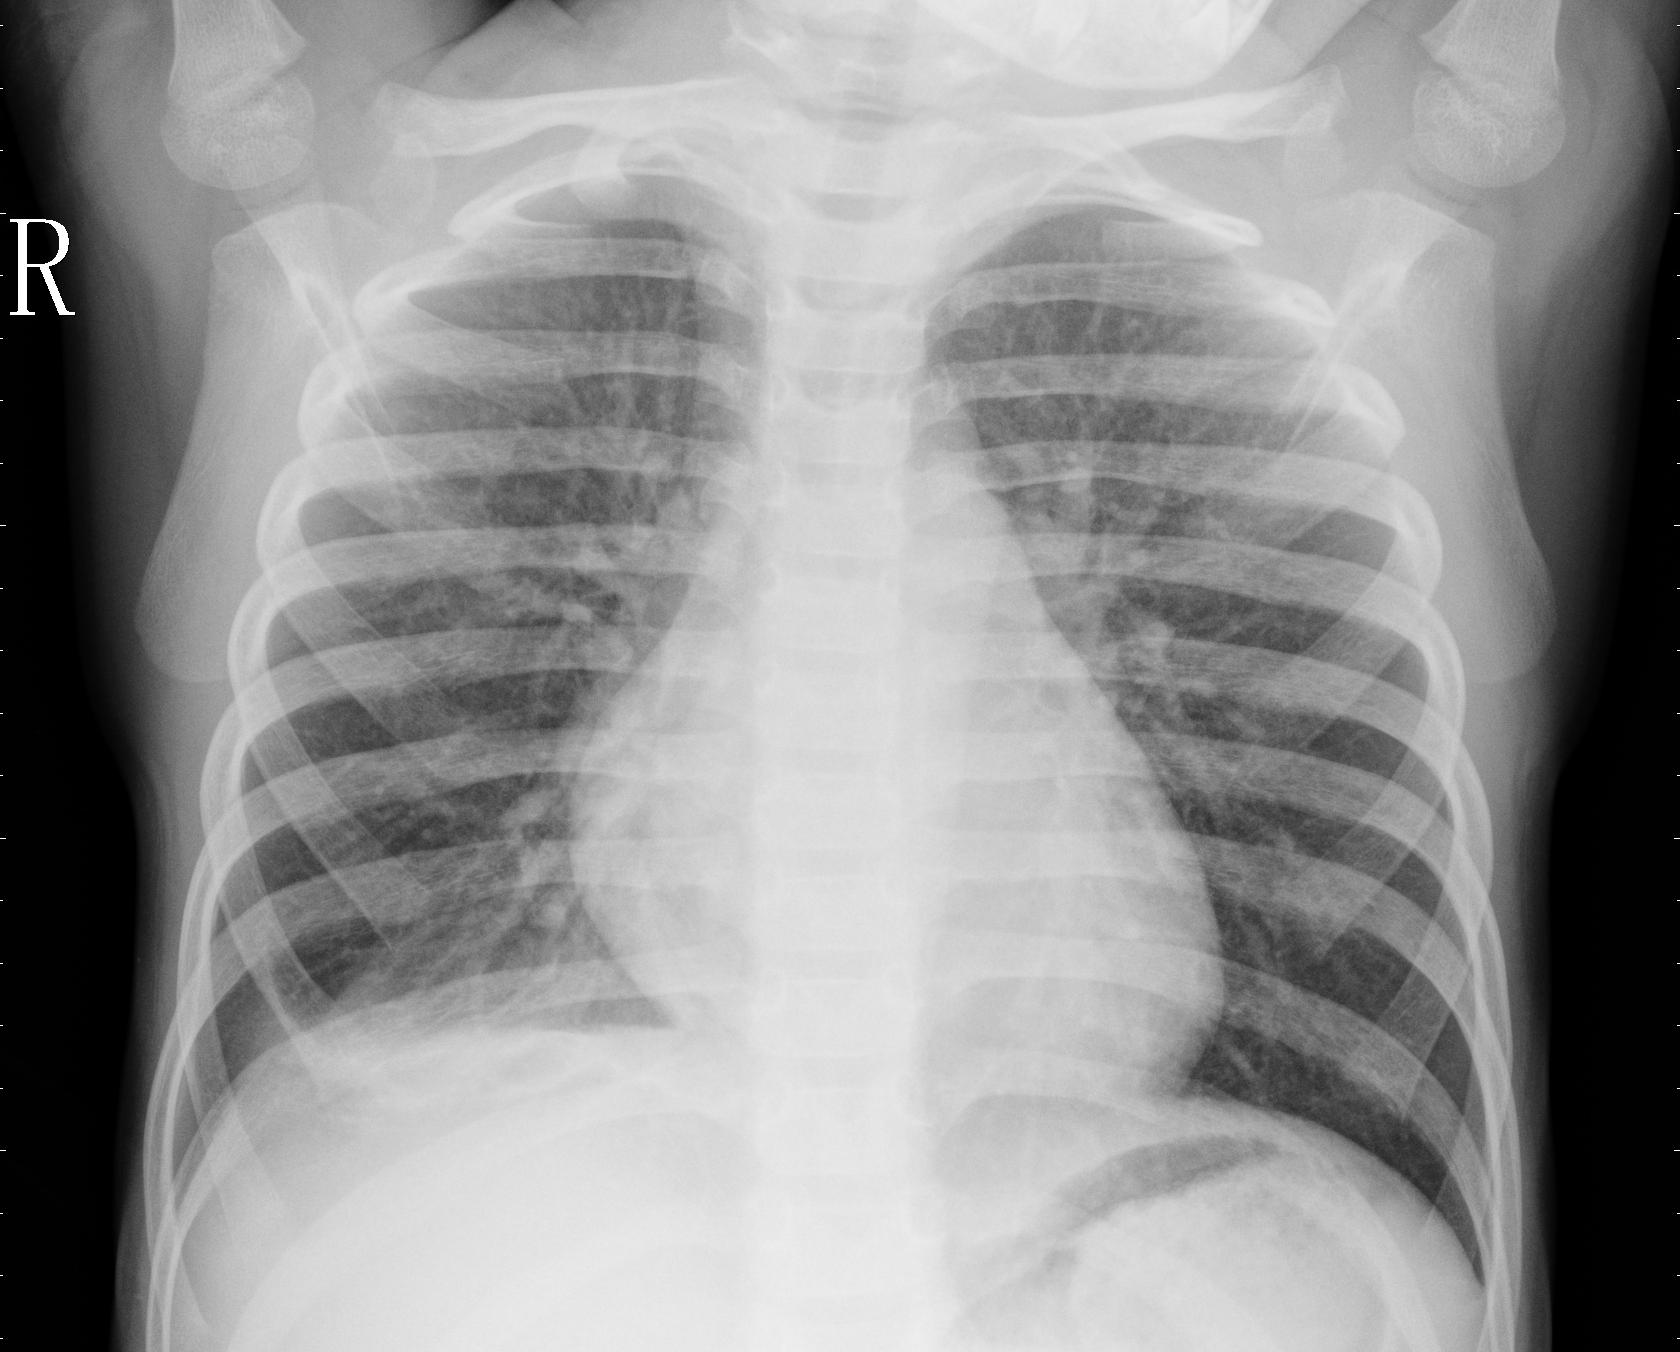

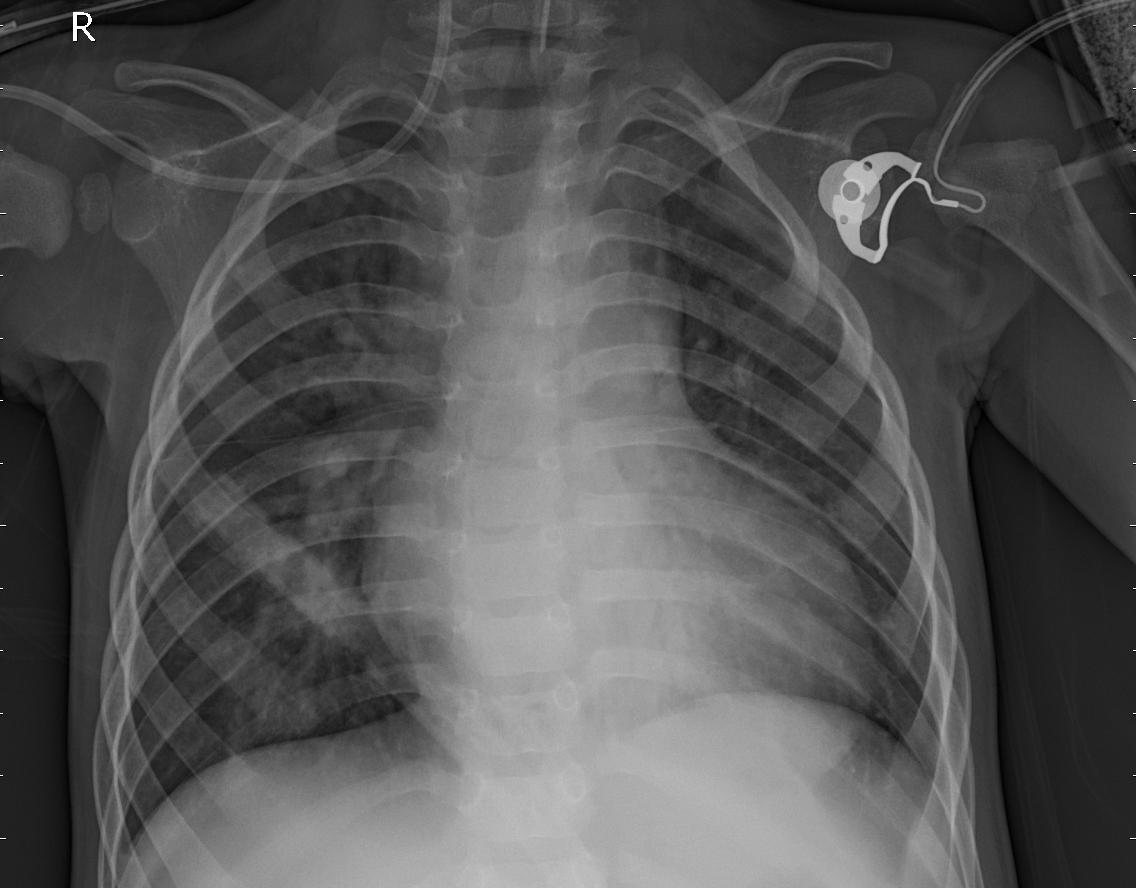

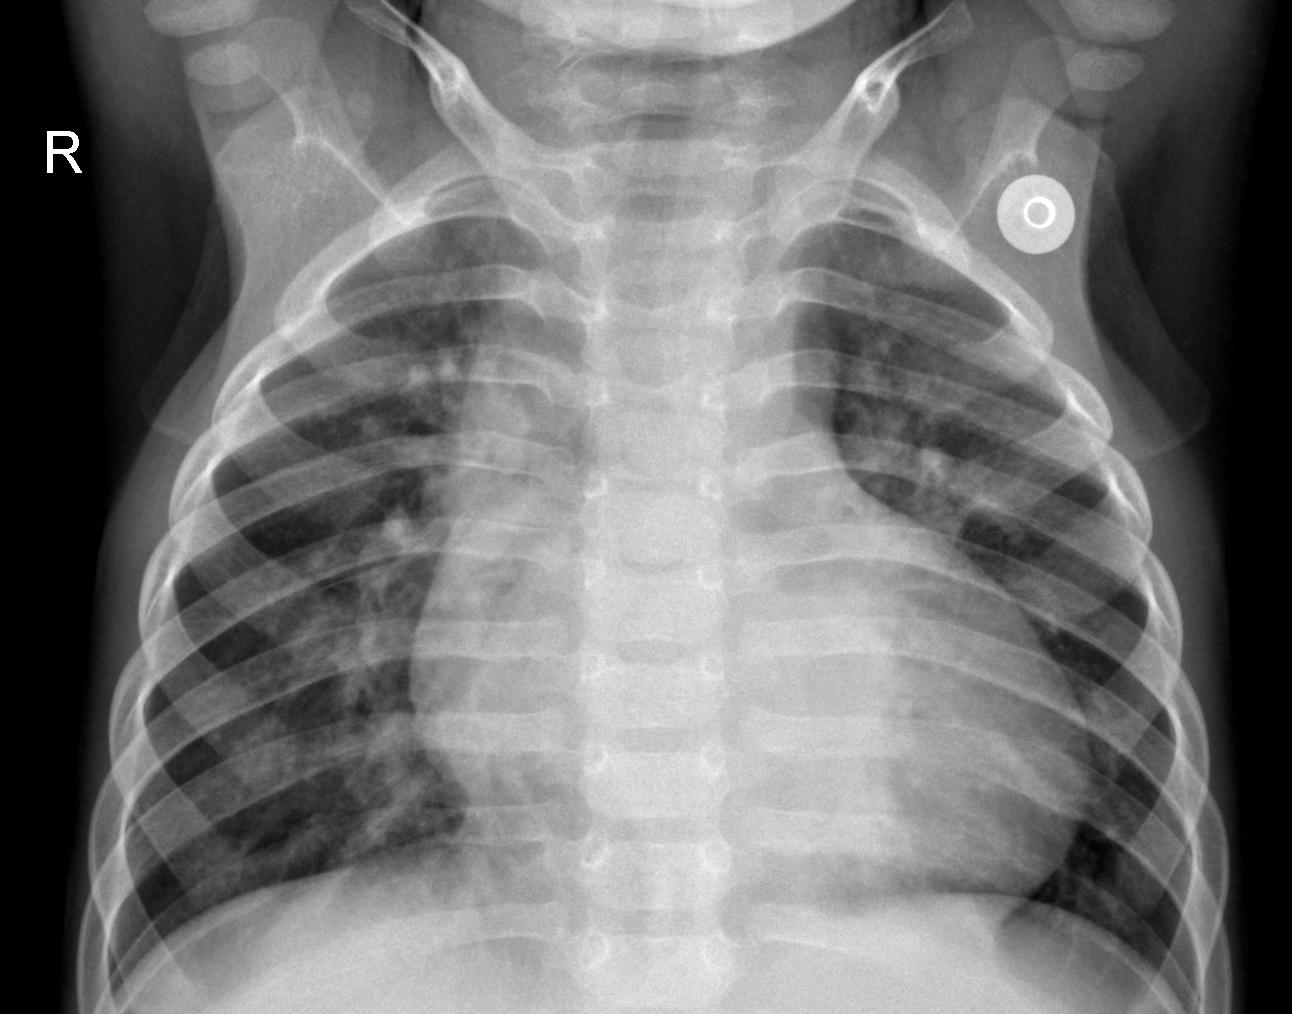

In [0]:
pneumonia = list(data_dir_train.glob('PNEUMONIA/*'))

for image_path in pneumonia[:3]:
    display.display(Image.open(str(image_path)))

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Define some parameters for the loader:

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_EPOCHS = 30
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir_train),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 5216 images belonging to 2 classes.


Inspect a batch:

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

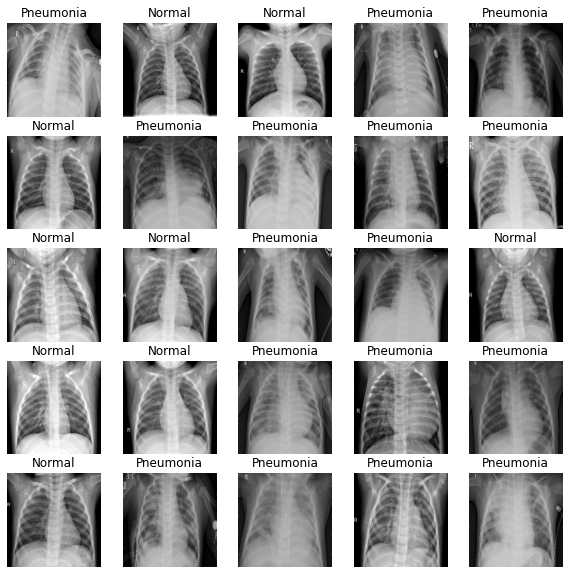

In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [0]:
list_ds_train = tf.data.Dataset.list_files(str(data_dir_train/'*/*'))
list_ds_val = tf.data.Dataset.list_files(str(data_dir_val/'*/*'))

In [0]:
for f in list_ds_train.take(5):
  print(f.numpy())

b'drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/person1496_virus_2605.jpeg'
b'drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/person501_bacteria_2113.jpeg'
b'drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg'
b'drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/person265_bacteria_1235.jpeg'
b'drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/person1670_bacteria_4427.jpeg'


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  #return parts[-2] == CLASS_NAMES
  return 0 if parts[-2] == 'NORMAL' else 1
  

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_val = list_ds_val.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
for image, label in labeled_ds_train.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  0


In [0]:


def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  # ds = ds.repeat()
  ds = ds.repeat(count=NUM_EPOCHS)

  ds = ds.batch(batch_size=BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds_val = prepare_for_training(labeled_ds_val)

In [0]:
train_ds_train = prepare_for_training(labeled_ds_train)

image_batch, label_batch = next(iter(train_ds_train))

In [0]:
#show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
def get_google_net_model(num_class):

    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

    x = tf.keras.layers.Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
    x = tf.keras.layers.MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
    x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
    x = tf.keras.layers.Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
    x = tf.keras.layers.MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = tf.keras.layers.MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
    x = inception_module(x, 192, 96, 208, 16, 48, 64)

    x1 = tf.keras.layers.AveragePooling2D((5, 5), strides=3)(x)
    x1 = tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(1024, activation='relu')(x1)
    x1 = tf.keras.layers.Dropout(0.7)(x1)
    x1 = tf.keras.layers.Dense(num_class, activation='softmax', name='auxilliary_output_1')(x1)

    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)

    x2 = tf.keras.layers.AveragePooling2D((5, 5), strides=3)(x)
    x2 = tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Dense(1024, activation='relu')(x2)
    x2 = tf.keras.layers.Dropout(0.7)(x2)
    x2 = tf.keras.layers.Dense(num_class, activation='softmax', name='auxilliary_output_2')(x2)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = tf.keras.layers.MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(x)

    return tf.keras.Model(input_layer, [x, x1], name='inception_v1')
    # return tf.keras.Model(input_layer, x, name='inception_v1')

def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):

    conv1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

    conv3 = tf.keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = tf.keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)

    conv5 = tf.keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = tf.keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)

    pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = tf.keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)

    layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [0]:
def get_alexnet_model(num_class):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2D(
            filters=12, kernel_size=(11,11), activation='relu',
            strides=(4,4), padding='valid', input_shape=(224, 224, 3)
        )
    )
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(
        tf.keras.layers.Conv2D(
            filters=256, kernel_size=(11,11), activation='relu',
            strides=(1,1), padding='valid'
            )
    )
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(
        tf.keras.layers.Conv2D(
            filters=48, kernel_size=(3,3), activation='relu',
            strides=(1,1), padding='valid'
            )
    )
    # model.add(
    #     tf.keras.layers.Conv2D(
    #         filters=48, kernel_size=(3,3), activation='relu',
    #         strides=(1,1), padding='valid'
    #         )
    # )
    model.add(
        tf.keras.layers.Conv2D(
            filters=32, kernel_size=(3,3), activation='relu',
            strides=(1,1), padding='valid'
            )
    )
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(125, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(num_class, activation='sigmoid'))
    return model

In [0]:
def get_vgg16_model(num_class):
    #spec = [64, 64, 128, 128, 256, 256, 512, 512, 512, 4096, 4096]
    spec = [4, 4, 8, 8, 16, 16, 32, 32, 32, 256, 256]
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2D(
            filters=spec[0], kernel_size=(3,3), activation='relu',
            padding='same', input_shape=(224, 224, 3)
        )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=spec[1], kernel_size=(3,3), activation='relu',
            padding='same'
        )
    )
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(
        tf.keras.layers.Conv2D(
            filters=spec[2], kernel_size=(3,3), activation='relu',
            padding='same'
        )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=spec[3], kernel_size=(3,3), activation='relu',
            padding='same'
        )
    )
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(
        tf.keras.layers.Conv2D(
            filters=spec[4], kernel_size=(3,3), activation='relu',
            padding='same'
            )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=spec[5], kernel_size=(3,3), activation='relu',
            padding='same'
            )
    )
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(
        tf.keras.layers.Conv2D(
            filters=spec[6], kernel_size=(3,3), activation='relu',
            padding='same'
            )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=spec[7], kernel_size=(3,3), activation='relu',
            padding='same'
            )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=spec[8], kernel_size=(3,3), activation='relu',
            padding='same'
            )
    )
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(spec[9], activation='relu'))
    model.add(tf.keras.layers.Dense(spec[10], activation='relu'))
    model.add(tf.keras.layers.Dense(num_class, activation='softmax'))
    return model

In [0]:
model = get_vgg16_model(2)
model.compile(loss=[tf.losses.SparseCategoricalCrossentropy()],
            optimizer=tf.optimizers.Adam(0.000001),
            metrics=['accuracy'])

In [0]:
history = model.fit(x=train_ds_train, epochs=NUM_EPOCHS, validation_data=train_ds_val, validation_steps=10)

Train for 4890 steps, validate for 10 steps
Epoch 1/30
4890/4890 [==============================] - 118s 24ms/step - loss: 0.5908 - accuracy: 0.7429 - val_loss: 0.8229 - val_accuracy: 0.5000
Epoch 2/30
4890/4890 [==============================] - 117s 24ms/step - loss: 0.5377 - accuracy: 0.7429 - val_loss: 0.7379 - val_accuracy: 0.5000
Epoch 3/30
4890/4890 [==============================] - 117s 24ms/step - loss: 0.3455 - accuracy: 0.8374 - val_loss: 0.9094 - val_accuracy: 0.6250
Epoch 4/30
4890/4890 [==============================] - 117s 24ms/step - loss: 0.2261 - accuracy: 0.9110 - val_loss: 0.9751 - val_accuracy: 0.6250
Epoch 5/30
4890/4890 [==============================] - 121s 25ms/step - loss: 0.1699 - accuracy: 0.9364 - val_loss: 0.9037 - val_accuracy: 0.6250
Epoch 6/30
4890/4890 [==============================] - 121s 25ms/step - loss: 0.1320 - accuracy: 0.9530 - val_loss: 0.7682 - val_accuracy: 0.6875
Epoch 7/30
4890/4890 [==============================] - 119s 24ms/step - l

In [0]:
def draw_result(H, N, name, val = False):
    fig, axs = plt.subplots(2)
    fig.suptitle('Training Loss and Accuracy on Dataset')
    for key, _ in H.history.items():
        if("loss" in key):
            axs[0].plot(np.arange(0, N), H.history[key], label=key)
    axs[0].set_xlabel("Epoch #")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc="lower right")
    for key, _ in H.history.items():
        if("accuracy" in key):
            axs[1].plot(np.arange(0, N), H.history[key], label=key)
    axs[1].set_xlabel("Epoch #")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc="lower right")
    plt.savefig(name + ".png")

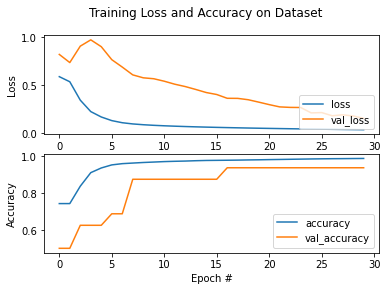

In [0]:
draw_result(history, NUM_EPOCHS, 'train')

In [0]:
model.save('drive/My Drive/Colab Notebooks/chest_xray/saved_model/pneumoniaVGG16V1') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/chest_xray/saved_model/pneumoniaVGG16V1/assets


In [0]:
model.evaluate(train_ds_val) 

15/15 [==============================] - 0s 14ms/step - loss: 0.1558 - accuracy: 0.9375


[0.15575132270654043, 0.9375]

In [0]:
!cp train.png 'drive/My Drive/Colab Notebooks/chest_xray/saved_model/pneumoniaVGG16V1.png'

In [0]:
!ls 'drive/My Drive/Colab Notebooks/chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0001.jpeg'

'drive/My Drive/Colab Notebooks/chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0001.jpeg'


In [0]:
img = tf.io.read_file('drive/My Drive/Colab Notebooks/chest_xray/test/PNEUMONIA/person1680_virus_2897.jpeg')
img = decode_img(img)
img = np.expand_dims(img, 0) # make 'batch' of 1
print(img.shape)

pred = model.predict(img)
print(pred)

(1, 224, 224, 3)
[[5.3993524e-08 1.0000000e+00]]
